**Summary:** 
This tutorial shows the basic functions and usages of btk. For a more detailed understanding of the btk pipeline refer to the [User Guide](https://blendingtoolkit.readthedocs.io/en/latest/user_guide.html) on the package [website](https://blendingtoolkit.readthedocs.io/en/latest/index.html). 

For instructions on how to download required dependencies take a look at this [page](https://blendingtoolkit.readthedocs.io/en/latest/install.html).

# Setup

In [1]:
# Autoreload packages in case they change.
%load_ext autoreload
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

In [3]:
sys.path.insert(0,os.path.dirname(os.getcwd())) # add BlendingToolKit so we can import btk 

In [4]:
import btk
import btk.plot_utils, btk.utils
from btk.create_observing_generator import ObservingGenerator
from btk.obs_conditions import CosmosObsConditions
from btk.create_blend_generator import BlendGenerator
from btk.sampling_functions import DefaultSampling
from btk.obs_conditions import Rubin, Euclid, Roman

import galsim
import astropy.table
import inspect
import descwl

In [5]:
import sklearn

In [6]:
import scarlet 
import scarlet.display

## Utility functions 

In [7]:
def make_histograms(*vals, labels=None, loc='best'):
    # make a histogram of each np.array in vals. 
    labels = labels if labels else [None]*len(vals)   
    bins = np.histogram(np.hstack(vals), bins=40)[1]  #get the bin edges
    for val, label in zip(vals, labels): 
        plt.hist(val, bins, label=label, histtype='step')
    plt.legend(loc=loc)

# Set Params 

In this first part we establish a set of parameters that we'll be using throughout the tutorial. You can think of them as user-defined global variables that are used throughout the simulations in BTK. 
These parameters will be fixed throughout this tutorial as well. 

Note that the `verbose` flag is turned off, in case you would like additional messages that show the functionality you can turn it on. 

In [8]:
catalog_names = [os.path.join('/Users/remy/Desktop/LSST_Project/GalSim/examples/', 
                            'data/COSMOS_25.2_training_sample', 
                            'real_galaxy_catalog_25.2.fits'),
                 os.path.join('/Users/remy/Desktop/LSST_Project/GalSim/examples/', 
                            'data/COSMOS_25.2_training_sample', 
                            'real_galaxy_catalog_25.2_fits.fits')]
galsim_catalog = galsim.COSMOSCatalog(catalog_names[0])
max_number = 6 # Number of galaxies in a stamp
batch_size = 2 # Number of stamps in a batch
stamp_size = 24.0 # Size of the desired stamp, in arcsecs (default to 24.0)
survey= Roman

np.random.seed(0)

# Load Catalog

Let's load the small catalog that we will be using. 

The file containing this catalog is defined in the `catalog_name` variable above.

In [9]:
catalog = btk.catalog.CosmosCatalog.from_file(catalog_names)
catalog_full = catalog.get_raw_catalog()

# as you can see this is just a astropy table. 
print(type(catalog_full))
print(len(catalog_full))

<class 'astropy.table.table.Table'>
87798


As you can see this catalog only contains 100 entries. 

In [10]:
# display available columns
catalog_full.colnames

['IDENT_1',
 'RA',
 'DEC',
 'MAG',
 'BAND',
 'WEIGHT',
 'GAL_FILENAME',
 'PSF_FILENAME',
 'GAL_HDU',
 'PSF_HDU',
 'PIXEL_SCALE',
 'NOISE_MEAN',
 'NOISE_VARIANCE',
 'NOISE_FILENAME',
 'stamp_flux',
 'IDENT_2',
 'mag_auto',
 'flux_radius',
 'zphot',
 'sersicfit',
 'bulgefit',
 'fit_status',
 'fit_mad_s',
 'fit_mad_b',
 'fit_dvc_btt',
 'use_bulgefit',
 'viable_sersic',
 'hlr',
 'flux',
 'ref_mag',
 'btk_size']

## Selection function 

One can optionally apply selection function at this step, there is the basic selection function already implemented inside BTK in `btk.utils` that we will use as an example: 

In [11]:
# After defining the function, you can use it like: 
catalog.apply_selection_function(btk.utils.basic_selection_function, 1, 25)
table = catalog.table
len(table)

76112

## Histograms 

Text(0.5, 0, 'reference magnitude')

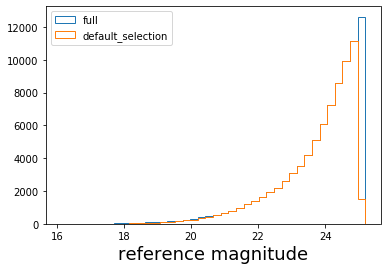

In [12]:
# let's see if our selection function is making sense by doing some histograms with the provided utility function.
labels = ['full', 'default_selection']
make_histograms(catalog_full['ref_mag'], table['ref_mag'], labels=labels, loc=2)
plt.xlabel('reference magnitude', size=18)

# Create blend generator 

A `generator` is python jargon - it's a convenient data structure that only returns one object at a time. Never loading all of the objects into memory at once. 

`BTK` uses generators to create batches of images and corresponding parameters on the fly. We will now work on an example. 

A `blend_generator` uses a `SamplingFunction` object which defines how BTK generates and returns blends (groups of galaxies in a postage stamp that are considered 'blended' and that are drawn together). As you might expect, a `SamplingFunction` is required by BTK, but a default one can be used. Even though the `SamplingFunction` is not a true function, it can be called like one, hence its name.

In [13]:
sampling_function = DefaultSampling(max_number,stamp_size) 
blend_generator = BlendGenerator(catalog, sampling_function, batch_size)

# Observing generator 

Now we turn to specifying the observational conditions for the blends created. Currently, the observing conditions are specified via the [WeakLensingDeblending](https://weaklensingdeblending.readthedocs.io/en/latest/) package (WLD), this package contains an object called `descwl.survey.Survey` that internally specifies observing conditions. Changeable parameters from the survey object include: 

- mirror_diameter
- effective_area 
- pixel_scale 
- airmass
- exposure_time
- sky_brightness 
- zenith_psf_fwhm
- zero_points
- extinction 

The PSF used for both the optics in the atmosphere are either a Moffat or Kolmogorov model. For more details see the [source code](https://github.com/ismael2395/WeakLensingDeblending/blob/master/descwl/survey.py) of `descwl.survey`.

The default observing conditions function in BTK are just constant across batches and will always return the defaults in the WLD package. 

In [14]:
observing_generator = ObservingGenerator(survey, 
                                         obs_conds = CosmosObsConditions(stamp_size),
                                         stamp_size=stamp_size)
# A None value for the obs_conditions create default conditions for each band, using WLDObsConditions(stamp_size=24)

# Draw blends

## Draw blend generator

Now we get to play with some images :) We will put together all the generators we have built so far and create some images simulated with `galsim` by interfacing with the WLD package and BTK. 

We first need one more generator created from the other two generators: `draw_blend_generator`

In [15]:
#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.CosmosGenerator(blend_generator, 
                                                       observing_generator, galsim_catalog) 

In [16]:
# This cell generates new `batch_size` number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

/anaconda3/lib/python3.7/site-packages/galsim/errors.py:429: GalSimWarning: A component to be convolved is not analytic in real space. Cannot use real space convolution. Switching to DFT method.
  warnings.warn(message, GalSimWarning)


In [17]:
output.keys()

dict_keys(['blend_images', 'isolated_images', 'blend_list', 'obs_condition'])

Note the following: 

- Each time the function `next` is used on `draw_blend_generator` a fresh batch of data is simulated (based on your pre-specified `blend_generator` and `observing_generator`.

- The output of the `draw_blend_generator` is a `dict` containing the following: 

    - `blend_images`: A `np.array` of shape `batch_size x stamp_size x stamp_size x n_bands`. This contains the actual postage stamps with the blends.
                        
    - `isolated_images`: A `np.array` of shape `batch_size x max_objects x stamp_size x stamp_size x n_bands`. This contains the images that were added together the create the `blend_images`.   
    
    - `blend_list`: A list of `astropy.Table`s containing the source catalog of each blend in the batch. 
    
    - `obs_condition`: A list of `batch_size` of list of `n_bands` observing conditions  `n_bands` that is used for every element in the batch. 
    
    - `wcs`: A list of `astropy.wcs.WCS` objects, which can be used to convert sky coordinates to pixel coordinates (and reverse)

## Draw some blends!

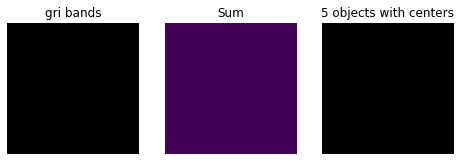

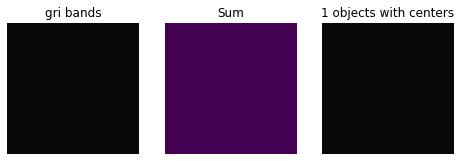

In [18]:
# Plot blended images
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(30,90))

#this also shows the true centers of the drawn galaxies with a red 'x'

In case you would also like to see each individual source in the blend you can take a look at the `isolated_images` 

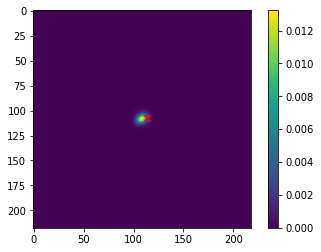

In [19]:
# plot the first source in the first blend in the 'i' band. 
# mark its appropriate position manually from the blend list. 
im = plt.imshow(isolated_images[0][0][...,3])
plt.scatter(blend_list[0][0]['dx'], blend_list[0][0]['dy'], marker='x', color='r')
plt.colorbar(im)


# Create Measure generator 

In this next part, we will see how we can combine the functionality of creating blends in BTK  with your favorite detection/deblending/measurement algorithms. 

For simplicity let's start by defining everything we did so far in one function. 

In [20]:
def get_draw_blend_generator():
    # Load parameters
    #Input catalog name
    catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sample_input_catalog.fits')
    batch_size = 2
    max_number = 5
    survey_name = "LSST"
    stamp_size = 24.0
    np.random.seed(0)

    #Load input catalog
    catalog = btk.catalog.WLDCatalog.from_file(catalog_name)

    #Generate catalogs of blended objects 
    blend_generator = btk.create_blend_generator.BlendGenerator(catalog,
                                                                btk.sampling_functions.DefaultSampling(max_number,stamp_size),
                                                                batch_size)

    #Generates observing conditions for the selected survey_name and all input bands
    observing_generator = btk.create_observing_generator.ObservingGenerator(survey,
                                                                            obs_conds=CosmosObsConditions(stamp_size), 
                                                                            stamp_size=stamp_size)

    #Generate images of blends in all the observing bands
    draw_blend_generator = btk.draw_blends.CosmosGenerator(blend_generator, observing_generator, galsim_catalog)
    return draw_blend_generator

In [21]:
draw_blend_generator = get_draw_blend_generator()

/anaconda3/lib/python3.7/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


Measurement/Deblending in BTK is structured very similarly to the previous approaches: using a generator. The reason for this is that the measurement might produce additional images or data that is later summarized, so it makes sense to not store it all at once but rather aggregate at the end if desired. 

The functionality that a user needs to add to BTK in order to specify their own algorithm is summarized in a class `btk.measure.Measurement_params`. You need to implement at least one of two functions:

- `make_measurement`: Given a dictionary `data` (`output` in the above section) return an astropy table with the measurements you made (fluxes, shapes, size, etc.) for each object in the blend. 

- `get_deblended_images`: Return output of deblending algorithm as dict. 

We will now walk through an example demonstration. 

Here is an example class to perform peak detection with sklearn that is copied from `btk.utils` :

## Basic Detection algorithm 

In [22]:
from btk.measure import Measurement_params
class Basic_measure_params(Measurement_params):
    """Class to perform detection by identifying peaks with skimage"""

    def get_centers(self, image):
        # set detection threshold to 5 times std of image
        threshold = 5 * np.std(image)
        coordinates = skimage.feature.peak_local_max(image, min_distance=2,
                                                     threshold_abs=threshold)
        return np.stack((coordinates[:, 1], coordinates[:, 0]), axis=1)

    def get_deblended_images(self, data, index):
        """Returns scarlet modeled blend and centers for the given blend"""
        image = np.mean(data['blend_images'][index], axis=2)  # don't use multi-band information. 
        peaks = self.get_centers(image)
        return {'deblend_image': None, 'peaks': peaks}

In [23]:
#this is how we specify the measurement params
meas_params = btk.utils.Basic_measure_params()

In [24]:
# get generator that yields measured values by running the algorithm in the images from the draw_blend_generator. 
# you can also turn on multiprocessing in this step in case your algorithm is CPU intensive. 
meas_generator = btk.measure.MeasureGenerator(
        meas_params, get_draw_blend_generator())

In [25]:
output, deb, _ = next(meas_generator)  # obtain simulation measurement output for this next batch. 
blend_list = output['blend_list']
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    detected_centers = deb[i]['peaks']
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    true_table = blend_list[i]
    det_table = astropy.table.Table(detected_centers, names=('dx', 'dy'))
    _, _, summary = btk.compute_metrics.evaluate_detection([true_table], [det_table], 0)
    det, undet, spur = summary[0][1:4]
    print("Out of %i objects, %i detected, %i undetected, & %i  spurious detections"%(len(true_centers), det, undet, spur))
    btk.plot_utils.plot_blends(blend_images, blend_list[i: i+1], [detected_centers],limits=(30,90))

KeyError: 'size'

We can see how to basic `skimage` algorithm misses detection when the amount of blending is considerable. 

## Deblending with Scarlet 

There is already an implementation of Scarlet as `Measurement_params`, take a look in `utils.measure.Scarlet_params`. We will walk through it step by step in this section. 

In [ ]:
# get output from draw_blend_generator and let's look at the blends. 
output = next(get_draw_blend_generator())
blend_images = output['blend_images']
blend_list = output['blend_list']
obs_conds = output['obs_condition']
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(30,90))

Let's try to deblend the second image which has two galaxies that look somewhat blended. 


In [ ]:
catalog = blend_list[1] 

#make the order of the axis convention match that of scarlet 
images = np.transpose(blend_images[1], axes=(2,0,1))  # shape = (6, 120, 120 )

bands = np.array([obs_cond.filter_band for obs_cond in obs_conds], dtype=str)

 # use the true peaks and organize them. 
peaks = np.stack((catalog['dx'], catalog['dy']), axis=1) 

First we define an utility function for obtaining the true PSF used to create the image. 

In [ ]:
from functools import partial 

def get_psf_sky(obs_cond, psf_stamp_size):
    """Returns postage stamp image of the PSF and mean background sky
    level value saved in the input obs_cond class
    Args:
        obs_cond:`descwl.survey.Survey` class describing observing
            conditions.
        psf_stamp_size: Size of postage stamp to draw PSF on in pixels.
    Returns:
        `np.ndarray`: Postage stamp image of PSF
        float: Mean of sky background

    """
    mean_sky_level = obs_cond.mean_sky_level
    psf = obs_cond.psf_model
    psf_image = psf.drawImage(
        scale=obs_cond.pixel_scale,
        nx=psf_stamp_size,
        ny=psf_stamp_size).array
    return psf_image, mean_sky_level

We now proceed to initialize scarlet, the following procedure is based heavily on the Scarlet tutorial which I recommend checking out: https://pmelchior.github.io/scarlet/0-quickstart.html

In [ ]:
#create model psf. 
model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(bands))

#create a frame for the model using the model_psf. 
model_frame = scarlet.Frame(
    images.shape,
    psfs=model_psf,
    channels=bands)

In [ ]:
# Now we need to do some setting up to define the observation. 
psf_stamp_size=41
n_bands = len(bands)
psfs = np.zeros((n_bands, psf_stamp_size, psf_stamp_size),
                dtype=np.float32)
variances = np.zeros_like(images)

for i in range(n_bands): 
    psf, mean_sky_level = get_psf_sky(
        obs_conds[i], psf_stamp_size)
    psfs[i] = psf
    variances[i] = images[i] + mean_sky_level


In [ ]:
# observation frame based on the image. 
observation = scarlet.Observation(
    images,
    psfs=scarlet.ImagePSF(psfs),
    weights=1. / variances,
    channels=bands).match(model_frame)

In [ ]:
#specify the fitting model using the true centers and some constraints. 
sources = []
for n, peak in enumerate(peaks):
    result = scarlet.ExtendedSource(
        model_frame, (peak[1], peak[0]), observation, thresh=1, shifting=True)
    sources.append(result)

In [ ]:
# perform the fit of the blended sscene. 
iters=200
blend = scarlet.Blend(sources, observation)
%time it, logL = blend.fit(iters, e_rel=1e-6)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

In [ ]:
# use an btk internal plotting tool to get the visualization. 
btk.plot_utils.show_scarlet_residual(blend, observation, limits=(30,90))

In [ ]:
# Looks pretty good :) 

In case you want to look at what this function is doing internally: 

In [ ]:
# get the model resulting form the fit and render it into the observationn frame
# these resizes the model to the original image size. 
model = blend.get_model()
model_ = observation.render(model)
residual = images-model_

# finally plot residual. 
plt.imshow(scarlet.display.img_to_rgb(residual))